In [ ]:
# default_exp engine.noise

In [ ]:
%load_ext autoreload
%autoreload 2

# Noise model

> Definition of the classes used to model the camera noise

In [ ]:
#export
from decode_fish.imports import *
from torch import nn
from torch import distributions as D

In [ ]:
#export
class sCMOS(nn.Module):
    """
    Generates sCMOS noise distribution.
    Generates sCMOS noise distribution which can be used for sampling and
    calculating log probabilites.

    Args:
        theta (float): Paramter for gamma distribution
        background (float): background value
        baseline (float): basline

    Shape:
        -Input: x_sim: (BS, C, H, W, D)

        -Output: Gamma(concentration: (BS, C, H, W, D), rate: 
        (BS, C, H, W, D))
    """
    def __init__(self,
                 theta: float = 3.,
                 baseline: float = 0.01):
        super().__init__()
        self.theta = torch.nn.Parameter(torch.tensor(theta))
        self.register_buffer('baseline', torch.tensor(baseline))

    def forward(self, x_sim, background):
        x_sim_background = x_sim +  background
        x_sim_background.clamp_(1.0)
        conc = (x_sim_background - self.baseline) / self.theta
        xsim_dist = D.Gamma(concentration=conc, rate=1 / self.theta)
        return xsim_dist

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.noise import sCMOS
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.microscope import Microscope
from decode_fish.funcs.plotting import plot_3d_projections

psf_state = torch.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/fishcod/simfish_psf.pkl')
_,xs,ys,zs = psf_state['psf_volume'].shape
psf = LinearInterpolatedPSF(fs_x=xs, fs_y=ys, fs_z=zs, upsample_factor= 1)
psf.load_state_dict(psf_state)

noise = sCMOS(theta=500.)

micro = Microscope(parametric_psf=[psf], noise=noise, multipl=1000).cuda()

point_process = PointProcessUniform(local_rate = torch.ones([1,1,48,48,48]).cuda()*.0001, min_int = 0.5)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)

background = torch.ones_like(xsim) * 500
xsim_noise = micro.noise(xsim, background).sample()

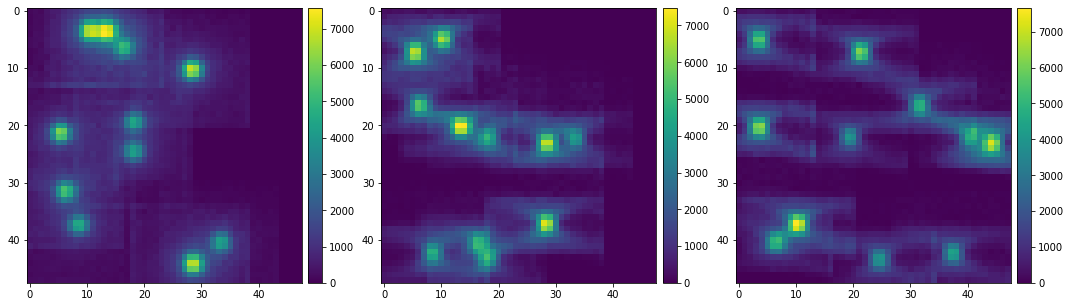

In [ ]:
plot_3d_projections(xsim[0,0])

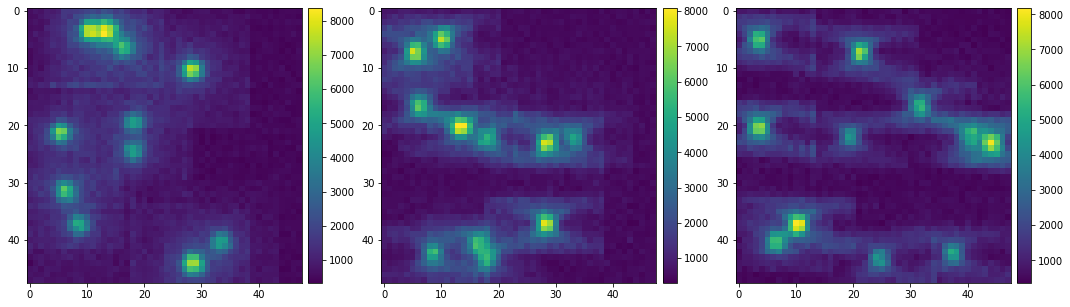

In [ ]:
plot_3d_projections(xsim_noise[0,0])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted index.ipynb.
